In [66]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import skew, kurtosis

## Understanding the Data

The full database consists of **lncRNA** (long non-enoding RNA) x **RBP** (RNA-Binding Protein) predicted binding interactions at each 101 nucleotide sequence along the lncRNAs resuling in an **36,000** dataframes of size **154** x **N<sub>i</sub>**, where **N<sub>i</sub>** represents the # of unique nucleotide segments in **lncRNA<sub>i</sub>** for **i = 1, ..., 36,000**.

Below is an example of the dataframe and and the predicted binding probabilites for **RBPs** (*AATF*, *ABCF1*, *AUH*, *BCCIP*,*BCLAF1*) along **lncRNA<sub>13</sub>** (*ENST00000366136.2*) with **N<sub>13</sub>** = 50.

,rna_index,dna_index,AATF,ABCF1,AUH,BCCIP
0,50,166081233,0.200273,0.090167,0.347747,0.292464
1,60,166081243,0.208896,0.069142,0.542808,0.458204
2,70,166082605,0.398123,0.108487,0.661721,0.344942
3,80,166082615,0.748078,0.381066,0.872924,0.845466
4,90,166082625,0.708046,0.460346,0.915495,0.981988


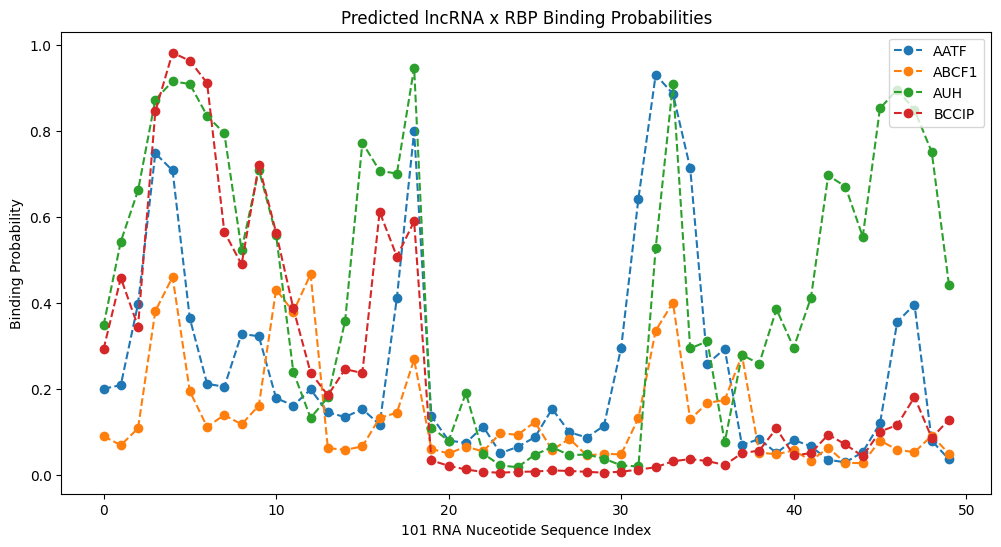

In [ ]:
path = r"C:\Users\simeo\OneDrive\Documents\UNC\Spring 2025\STOR 765\lncRNA_x_RBP_Data\chr1\ENST00000366136.2_predictions.tsv"
df = pd.read_csv(path, sep='\t')
display(df.iloc[:, :6].head())

plt.figure(figsize=(12, 6))
for rbp in df.columns[2:6]:
    plt.plot(range(len(df)), df[rbp], marker='o', linestyle='--', label=rbp)
plt.title('Predicted lncRNA x RBP Binding Probabilities')
plt.xlabel('101 RNA Nuceotide Sequence Index')
plt.ylabel('Binding Probability')
plt.legend(loc='upper right')
plt.show()
# convert to percentage

This code creates a series of subplots to visualize the binding probabilities of RNA-binding proteins (RBPs) and their statistical properties within percentile bins. Each subplot shows the following:

1. **Binding Probabilities**: The binding probabilities of the RBP across the RNA sequence are plotted as a black dashed line with markers.
2. **Mean and Median Index Values**: The mean and median index values for each percentile bin are plotted as red scatter points.
3. **Error Bars**: Horizontal dashed lines represent the standard deviation around the mean index values.
4. **Bin Edges**: Horizontal dashed lines indicate the edges of the percentile bins.

The subplots provide a detailed view of the distribution and variability of binding probabilities for the first four RBPs in the dataset.

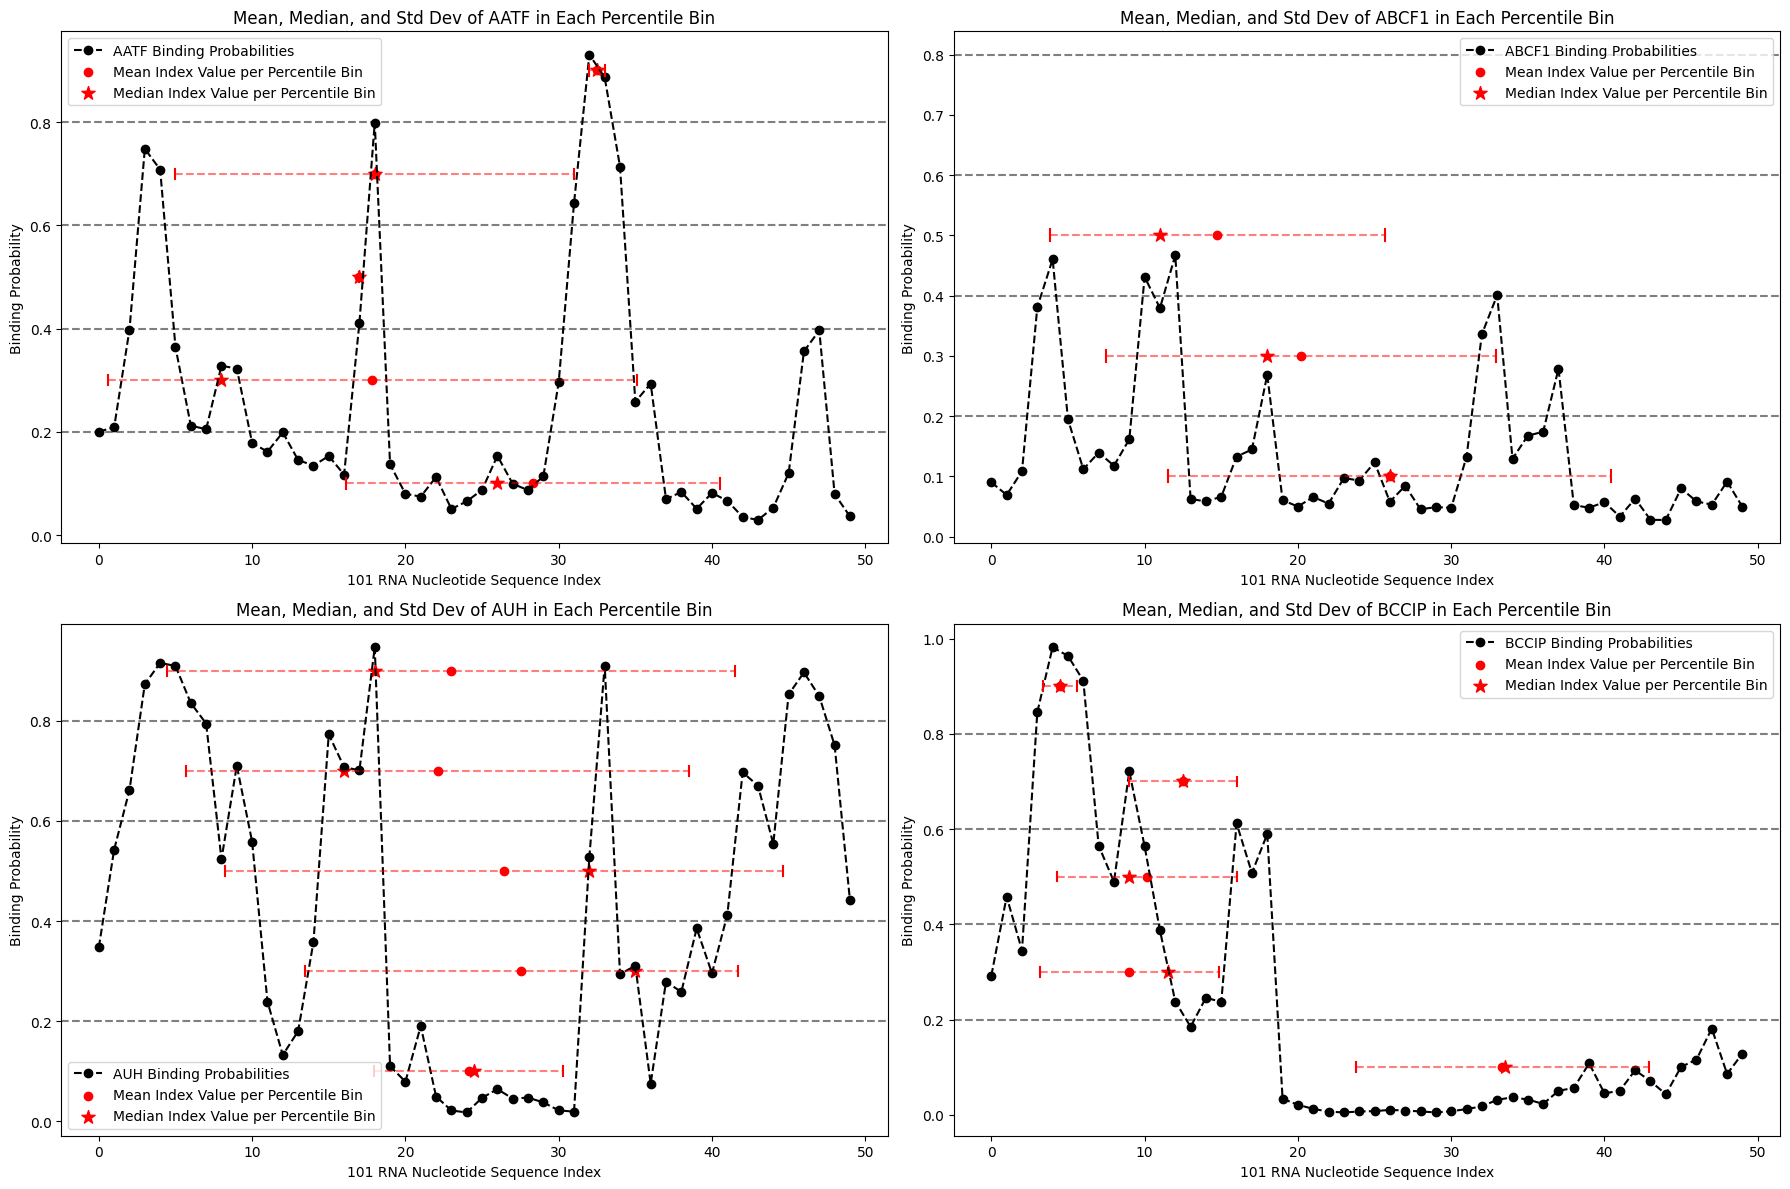

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
for ax, rbp in zip(axes.flatten(), df.columns[2:6]):
    N = 5
    bps = df[rbp].values
    bins = np.linspace(0, 1, N + 1)
    bin_indices = np.digitize(bps, bins) - 1
    average_index_values = []
    variance_index_values = []
    median_index_values = []
    for i in range(N):
        indices_in_bin = np.where(bin_indices == i)[0]
        if len(indices_in_bin) > 0:
            average_index_values.append(indices_in_bin.mean())
            variance_index_values.append(indices_in_bin.var())
            median_index_values.append(np.median(indices_in_bin))
        else:
            average_index_values.append(np.nan)
            variance_index_values.append(np.nan)
            median_index_values.append(np.nan)
    y_coordinates = [(bins[i] + bins[i + 1]) / 2 for i in range(N)]
    ax.plot(range(len(df)), df[rbp], marker='o', linestyle='--', color='black', label=rbp + ' Binding Probabilities')
    ax.scatter(average_index_values, y_coordinates, color='red', label='Mean Index Value per Percentile Bin')
    ax.scatter(median_index_values, y_coordinates, color='red', marker='*', s=100, label='Median Index Value per Percentile Bin')
    for i in range(N):
        if not np.isnan(average_index_values[i]):
            lower_bound = average_index_values[i] - np.sqrt(variance_index_values[i])
            upper_bound = average_index_values[i] + np.sqrt(variance_index_values[i])
            ax.hlines(y_coordinates[i], lower_bound, upper_bound, colors='red', linestyles='dashed', alpha=0.5)
            ax.plot([lower_bound, lower_bound], [y_coordinates[i] - 0.01, y_coordinates[i] + 0.01], color='red')
            ax.plot([upper_bound, upper_bound], [y_coordinates[i] - 0.01, y_coordinates[i] + 0.01], color='red')
    for y in bins[1:-1]:
        ax.axhline(y, color='black', linestyle='--', alpha=0.5)
    ax.set_title(f'Mean, Median, and Std Dev of {rbp} in Each Percentile Bin')
    ax.set_xlabel('101 RNA Nucleotide Sequence Index')
    ax.set_ylabel('Binding Probability')
    ax.legend()
plt.tight_layout()
plt.show()


This code creates a series of subplots to visualize various statistical properties of RNA-binding proteins (RBPs) within percentile bins. Each subplot shows the following:

1. **Proportion of Binding Probabilities**: The proportion of binding probabilities in each percentile bin.
2. **Mean Index of Binding Probabilities**: The mean index values of binding probabilities in each percentile bin.
3. **Variance of Index of Binding Probabilities**: The variance of index values of binding probabilities in each percentile bin.
4. **Skewness of Index of Binding Probabilities**: The skewness of index values of binding probabilities in each percentile bin.

The subplots provide a detailed view of the distribution and variability of binding probabilities for the first four RBPs in the dataset.

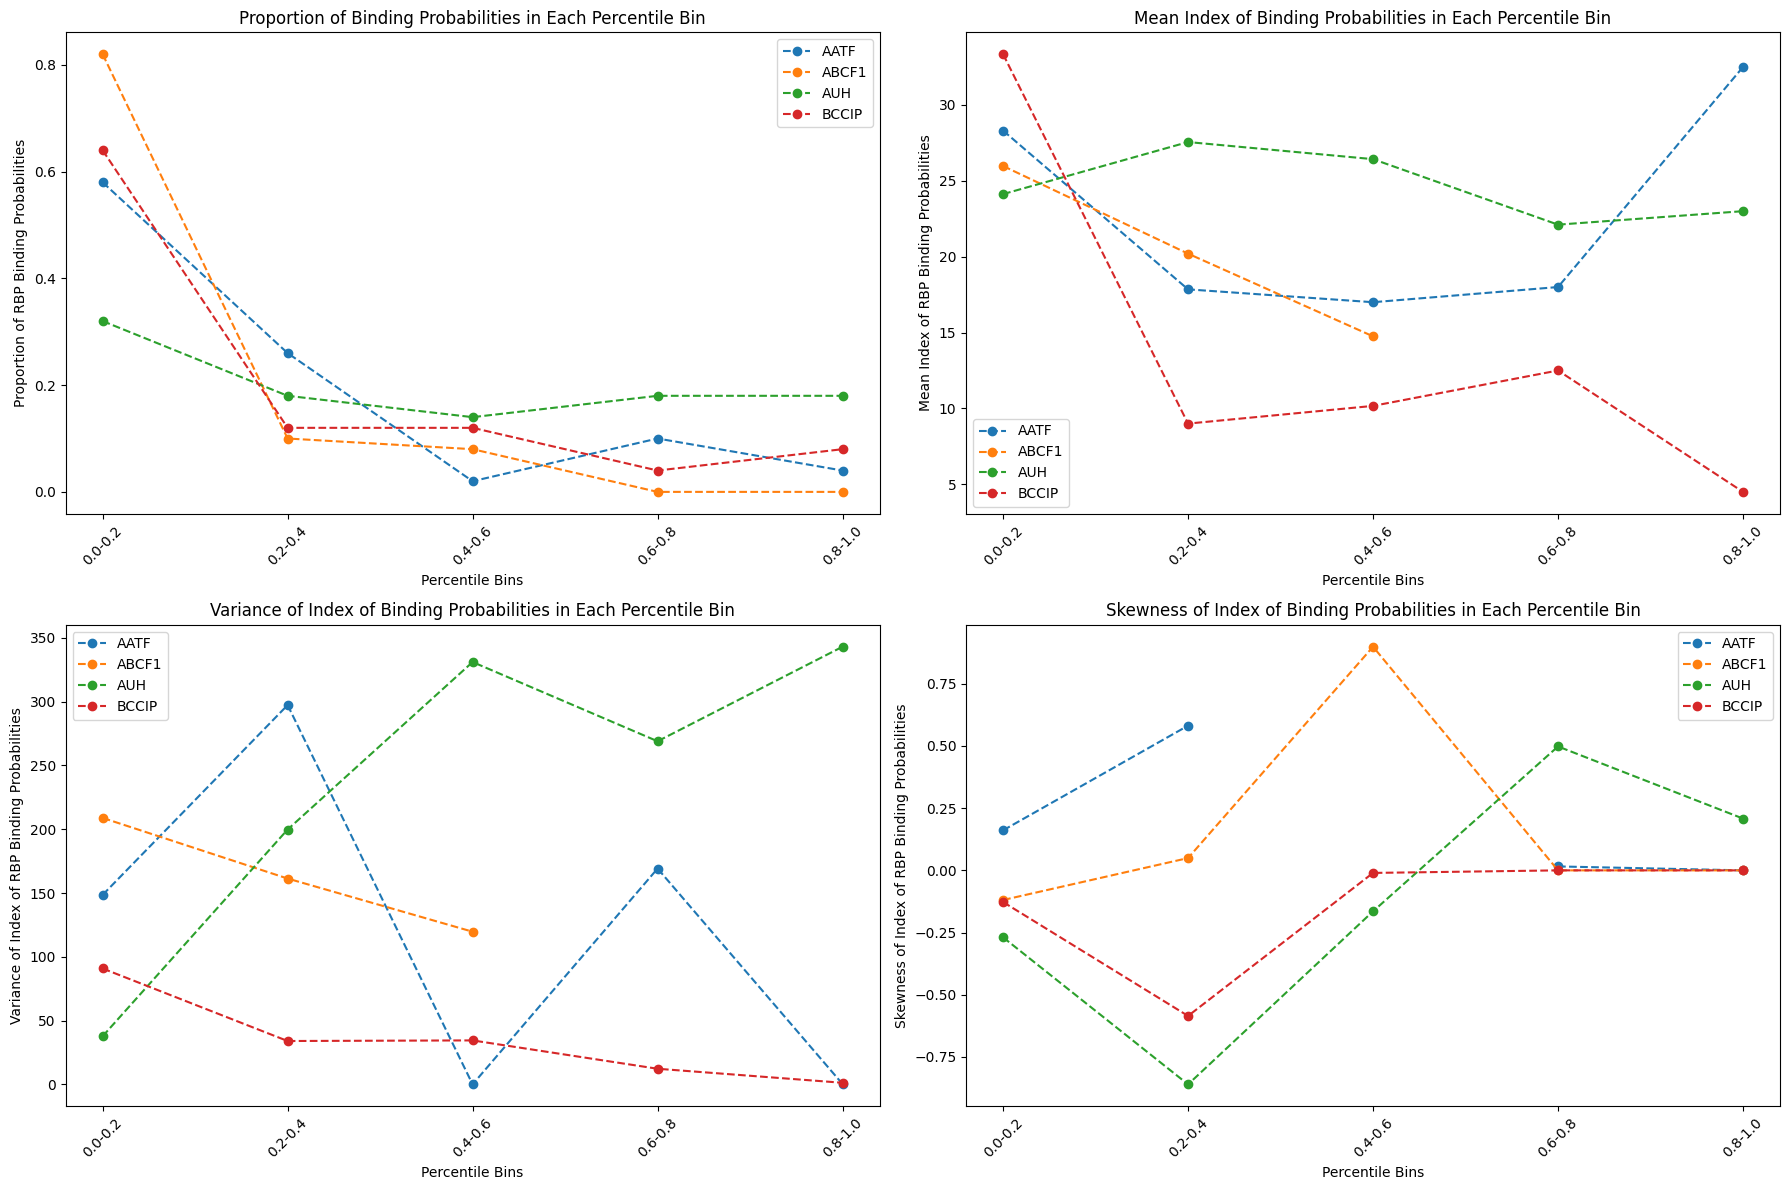

In [94]:
proportion_dict, mean_index_dict, variance_index_dict, skew_index_dict = {}, {}, {}, {}
N = 5
indices = np.arange(50, 50 + 10 * len(df), 10)
for rbp in df.columns[2:6]:
    bps = df[rbp].values
    bins = np.linspace(0, 1, N + 1)
    bin_indices = np.digitize(bps, bins) - 1
    average_index_values = []
    variance_index_values = []
    median_index_values = []
    for i in range(N):
        indices_in_bin = np.where(bin_indices == i)[0]
        if len(indices_in_bin) > 0:
            average_index_values.append(indices_in_bin.mean())
            variance_index_values.append(indices_in_bin.var())
            median_index_values.append(np.median(indices_in_bin))
        else:
            average_index_values.append(np.nan)
            variance_index_values.append(np.nan)
            median_index_values.append(np.nan)
    proportion_dict[rbp] = [len(np.where(bin_indices == i)[0]) / len(indices) for i in range(N)]
    mean_index_dict[rbp] = average_index_values
    variance_index_dict[rbp] = variance_index_values
    skew_index_dict[rbp] = [skew(indices[np.where(bin_indices == i)[0]]) if len(np.where(bin_indices == i)[0]) > 0 else 0 for i in range(N)]
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
for ax, (var_dict, title, ylabel) in zip(axes.flatten(), 
                                         [(proportion_dict, 'Proportion of Binding Probabilities in Each Percentile Bin', 'Proportion of RBP Binding Probabilities'),
                                          (mean_index_dict, 'Mean Index of Binding Probabilities in Each Percentile Bin', 'Mean Index of RBP Binding Probabilities'),
                                          (variance_index_dict, 'Variance of Index of Binding Probabilities in Each Percentile Bin', 'Variance of Index of RBP Binding Probabilities'),
                                          (skew_index_dict, 'Skewness of Index of Binding Probabilities in Each Percentile Bin', 'Skewness of Index of RBP Binding Probabilities')]):
    for rbp in var_dict:
        ax.plot(range(N), var_dict[rbp], marker='o', linestyle='--', label=rbp)
    ax.set_title(title)
    ax.set_xlabel('Percentile Bins')
    ax.set_ylabel(ylabel)
    ax.set_xticks(range(N))
    ax.set_xticklabels([f'{i/N:.1f}-{(i+1)/N:.1f}' for i in range(N)], rotation=45)
    ax.legend()
plt.tight_layout()
plt.show()

This code creates a series of subplots to visualize the binding probabilities of RNA-binding proteins (RBPs) and their Fourier Transform reconstructions. Each subplot shows the following:

1. **Original Binding Probabilities**: The original binding probabilities of the RBP across the RNA sequence are plotted as a semi-transparent line.
2. **Fourier Reconstruction**: The reconstructed signal using the top K Fourier components is plotted as dashed lines for different values of K (3, 7, and 12).

The subplots provide a comparison between the original binding probabilities and their Fourier Transform reconstructions, highlighting how well the top K Fourier components capture the signal.

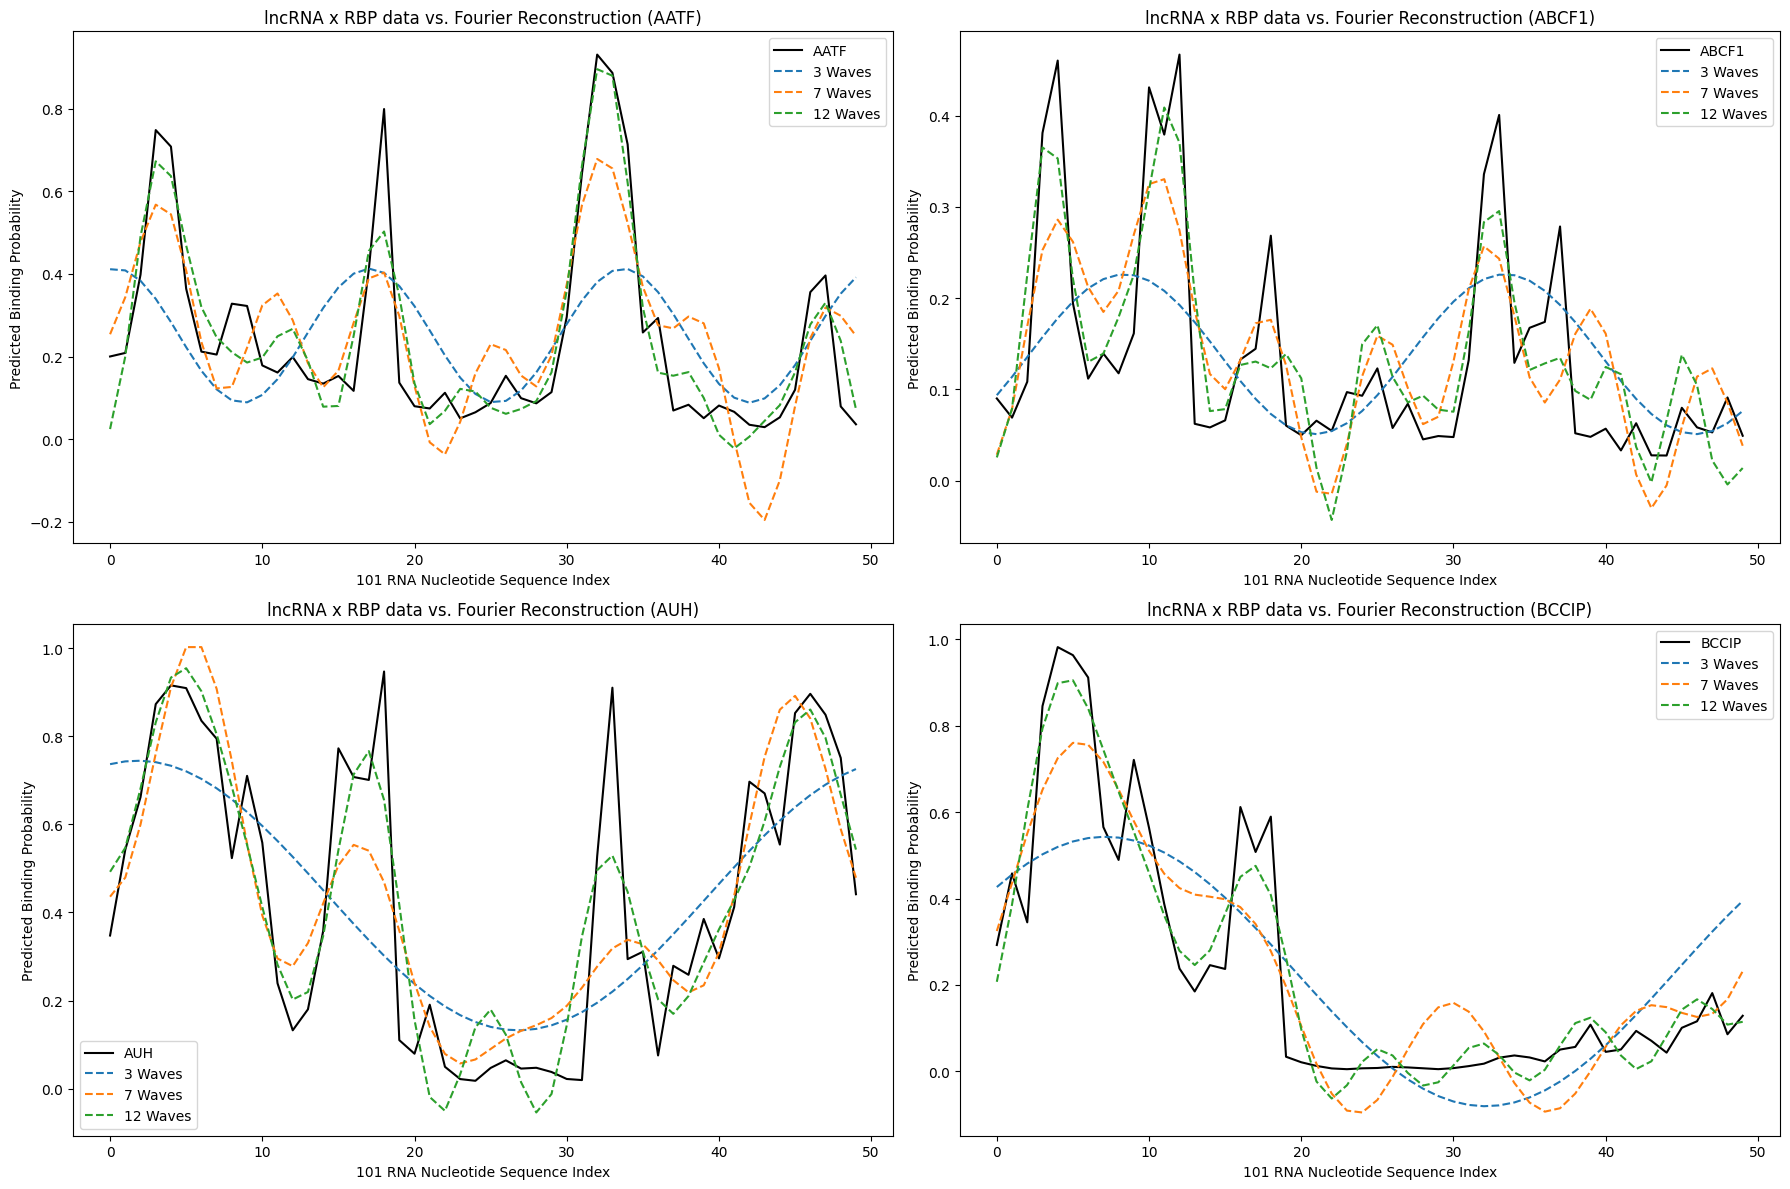

In [93]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
for ax, rbp in zip(axes.flatten(), df.columns[2:6]):
    bps = df[rbp].values
    N = len(bps)
    K = [3, 7, 12]
    bps_fft = np.fft.fft(bps)
    freqs = np.fft.fftfreq(N, d=1)
    magnitudes = np.abs(bps_fft) / N
    indices_sorted = np.argsort(magnitudes)[::-1]
    ax.plot(np.arange(N), bps, label=rbp, color='black')
    for k in K:
        top_indices = indices_sorted[:k]
        filtered_fft = np.zeros_like(bps_fft, dtype=complex)
        filtered_fft[top_indices] = bps_fft[top_indices]
        filtered_fft[-top_indices] = bps_fft[-top_indices]
        y_reconstructed = np.fft.ifft(filtered_fft).real
        ax.plot(np.arange(N), y_reconstructed, label=f'{k} Waves', linestyle='--')
    ax.set_title(f"lncRNA x RBP data vs. Fourier Reconstruction ({rbp})")
    ax.set_xlabel('101 RNA Nucleotide Sequence Index')
    ax.set_ylabel('Predicted Binding Probability')
    ax.legend()
plt.tight_layout()
plt.show()

## Extracting Features

The `process_file` function processes a given file containing lncRNA x RBP predicted binding interactions and extracts various features. Here is a summary of its steps:

1. **Read Data**: Reads the input file into a DataFrame.
2. **Initialize Variables**: Sets up variables for the number of bins (`N`), top Fourier frequencies (`K`), and autocorrelation lags (`L`).
3. **Percentile-based Summary Statistics**:
    - Bins the binding probabilities for each protein into `N` bins = [0 , 1/N] , ... , [N-1/N , 1].
    - Calculates the proportion, mean, variance, and skew forming the distribution of binding probabilites within each bin.
    - Stores the binned summary statistics in a dictionary.
4. **Top K Fourier Frequencies and Magnitudes**:
    - Computes the Fourier transform of the signal for each protein.
    - Extracts the top `K` more relevant frequencies and their respective magnitudes.
    - Stores these values in the dictionary.
5. **Autocorrelation**:
    - Computes the autocorrelation of binding probabilties between each pair of proteins for lags = 0, ..., `L`.
    - Stores these values in the dictionary.
6. **Convert to DataFrame**: Converts the dictionary of features into a single-row DataFrame and returns it.

In [ ]:
def feature_extraction(file_path):
    df = pd.read_csv(file_path, sep='\t')
    RBPs = df.columns[2:]
    N, K, L = 5, 3, 0
    dict = {}
    for rbp in df.columns[2:6]:
        bps = df[rbp].values
        bins = np.linspace(0, 1, N + 1)
        bin_indices = np.digitize(bps, bins) - 1
        average_index_values = []
        variance_index_values = []
        median_index_values = []
        for i in range(N):
            indices_in_bin = np.where(bin_indices == i)[0]
            if len(indices_in_bin) > 0:
                average_index_values.append(indices_in_bin.mean())
                variance_index_values.append(indices_in_bin.var())
                median_index_values.append(np.median(indices_in_bin))
            else:
                average_index_values.append(np.nan)
                variance_index_values.append(np.nan)
                median_index_values.append(np.nan)
        dict[f'{rbp}_percentile_proportion'] = [len(np.where(bin_indices == i)[0]) / len(bps) for i in range(N)]
        dict[f'{rbp}_percentile_mean'] = average_index_values
        dict[f'{rbp}_percentile_variance'] = variance_index_values
        dict[f'{rbp}_percentile_skew'] = [skew(indices[np.where(bin_indices == i)[0]]) if len(np.where(bin_indices == i)[0]) > 0 else 0 for i in range(N)]
        N_i = len(bps)
        fft_vals = np.fft.rfft(bps)
        mags = np.abs(fft_vals)
        freqs = np.fft.fftfreq(N_i, d=1)
        top_k_idx = np.argsort(mags)[-K:]
        for k in range(K):
            rank = k + 1
            idx = top_k_idx[-(rank)] 
            dict[f'{rbp}_Frequency_{rank}']  = freqs[idx]
            dict[f'{rbp}_Magnitude_{rank}']  = mags[idx]
            for rbp2 in RBPs:
                if rbp <= rbp2:
                    for l in range(L+1):
                        dict[f'{rbp}_x_{rbp2}_Autocorrelation({l})'] = np.corrcoef(df[rbp].values, np.roll(df[rbp2].values, l))[0, 1]
        return pd.DataFrame([dict])

In [ ]:
directory_path = r"C:\Users\simeo\OneDrive\Documents\UNC\Spring 2025\STOR 765\lncRNA_x_RBP_Data"
combined_df, row_names, error_files = [] , [], []
processed_files = 0
files = [os.path.join(folder_path, filename)
         for folder in os.listdir(directory_path)
         if os.path.isdir(folder_path := os.path.join(directory_path, folder))
         for filename in os.listdir(folder_path)
         if filename.endswith(".tsv")]
with tqdm(files, desc="Extracting Features", unit="lncRNA") as pbar:
    for path in pbar:
        try:
            combined_df.append(feature_extraction(path))
            row_names.append(os.path.basename(path).replace("_predictions.tsv", ""))
            processed_files += 1
        except Exception as e:
            error_files.append(path)
            continue
final_df = pd.concat(combined_df).set_index(pd.Index(row_names))
final_df

Processing files:   2%|▏         | 284/13862 [01:06<50:38,  4.47it/s]  

Error processing file C:\Users\simeo\OneDrive\Documents\UNC\Spring 2025\STOR 765\Inc_RNA_Protein_Interatctions_Data\chr1\ENST00000426090.1_predictions.tsv: index -3 is out of bounds for axis 0 with size 2


Processing files:   7%|▋         | 965/13862 [03:48<46:17,  4.64it/s]  

Error processing file C:\Users\simeo\OneDrive\Documents\UNC\Spring 2025\STOR 765\Inc_RNA_Protein_Interatctions_Data\chr1\ENST00000607951.1_predictions.tsv: index -3 is out of bounds for axis 0 with size 2


Processing files:  17%|█▋        | 2298/13862 [09:03<43:49,  4.40it/s]  

Error processing file C:\Users\simeo\OneDrive\Documents\UNC\Spring 2025\STOR 765\Inc_RNA_Protein_Interatctions_Data\chr11\ENST00000625165.1_predictions.tsv: index -3 is out of bounds for axis 0 with size 2


Processing files:  22%|██▏       | 3109/13862 [12:15<44:19,  4.04it/s]  

Error processing file C:\Users\simeo\OneDrive\Documents\UNC\Spring 2025\STOR 765\Inc_RNA_Protein_Interatctions_Data\chr12\ENST00000624512.1_predictions.tsv: index -3 is out of bounds for axis 0 with size 2


Processing files:  33%|███▎      | 4576/13862 [18:05<40:15,  3.85it/s]  

Error processing file C:\Users\simeo\OneDrive\Documents\UNC\Spring 2025\STOR 765\Inc_RNA_Protein_Interatctions_Data\chr15\ENST00000624172.1_predictions.tsv: index -3 is out of bounds for axis 0 with size 2


Processing files:  39%|███▉      | 5440/13862 [21:38<33:25,  4.20it/s]

Error processing file C:\Users\simeo\OneDrive\Documents\UNC\Spring 2025\STOR 765\Inc_RNA_Protein_Interatctions_Data\chr16\ENST00000625055.1_predictions.tsv: index -3 is out of bounds for axis 0 with size 2


Processing files:  44%|████▍     | 6099/13862 [24:24<32:25,  3.99it/s]

Error processing file C:\Users\simeo\OneDrive\Documents\UNC\Spring 2025\STOR 765\Inc_RNA_Protein_Interatctions_Data\chr17\ENST00000609567.1_predictions.tsv: index -2 is out of bounds for axis 0 with size 1


Processing files:  44%|████▍     | 6166/13862 [24:41<31:26,  4.08it/s]

Error processing file C:\Users\simeo\OneDrive\Documents\UNC\Spring 2025\STOR 765\Inc_RNA_Protein_Interatctions_Data\chr17\ENST00000620112.1_predictions.tsv: index -3 is out of bounds for axis 0 with size 2


Processing files:  45%|████▍     | 6226/13862 [24:55<30:34,  4.16it/s]

Error processing file C:\Users\simeo\OneDrive\Documents\UNC\Spring 2025\STOR 765\Inc_RNA_Protein_Interatctions_Data\chr17\ENST00000623952.1_predictions.tsv: index -3 is out of bounds for axis 0 with size 2


Processing files:  45%|████▌     | 6247/13862 [25:00<31:40,  4.01it/s]

Error processing file C:\Users\simeo\OneDrive\Documents\UNC\Spring 2025\STOR 765\Inc_RNA_Protein_Interatctions_Data\chr17\ENST00000624486.1_predictions.tsv: index -3 is out of bounds for axis 0 with size 2


Processing files:  51%|█████     | 7045/13862 [28:19<27:02,  4.20it/s]

Error processing file C:\Users\simeo\OneDrive\Documents\UNC\Spring 2025\STOR 765\Inc_RNA_Protein_Interatctions_Data\chr19\ENST00000594678.1_predictions.tsv: index -3 is out of bounds for axis 0 with size 2


Processing files:  63%|██████▎   | 8741/13862 [35:36<22:58,  3.72it/s]

Error processing file C:\Users\simeo\OneDrive\Documents\UNC\Spring 2025\STOR 765\Inc_RNA_Protein_Interatctions_Data\chr21\ENST00000426029.1_predictions.tsv: index -3 is out of bounds for axis 0 with size 2


Processing files:  65%|██████▌   | 9023/13862 [36:50<20:41,  3.90it/s]

Error processing file C:\Users\simeo\OneDrive\Documents\UNC\Spring 2025\STOR 765\Inc_RNA_Protein_Interatctions_Data\chr22\ENST00000422833.1_predictions.tsv: index -3 is out of bounds for axis 0 with size 2


Processing files:  85%|████████▌ | 11807/13862 [49:39<09:11,  3.73it/s] 

Error processing file C:\Users\simeo\OneDrive\Documents\UNC\Spring 2025\STOR 765\Inc_RNA_Protein_Interatctions_Data\chr6\ENST00000604792.1_predictions.tsv: index -3 is out of bounds for axis 0 with size 2


Processing files:  92%|█████████▏| 12720/13862 [54:01<05:14,  3.63it/s]

Error processing file C:\Users\simeo\OneDrive\Documents\UNC\Spring 2025\STOR 765\Inc_RNA_Protein_Interatctions_Data\chr8\ENST00000520185.1_predictions.tsv: index -2 is out of bounds for axis 0 with size 1


Processing files:  95%|█████████▍| 13123/13862 [55:54<03:27,  3.56it/s]

Error processing file C:\Users\simeo\OneDrive\Documents\UNC\Spring 2025\STOR 765\Inc_RNA_Protein_Interatctions_Data\chr8\ENST00000623465.1_predictions.tsv: index -3 is out of bounds for axis 0 with size 2


Processing files:  95%|█████████▍| 13129/13862 [55:55<03:10,  3.84it/s]

Error processing file C:\Users\simeo\OneDrive\Documents\UNC\Spring 2025\STOR 765\Inc_RNA_Protein_Interatctions_Data\chr8\ENST00000623880.1_predictions.tsv: index -3 is out of bounds for axis 0 with size 2


Processing files: 100%|██████████| 13862/13862 [59:38<00:00,  3.87it/s]


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardize the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(final_combined_df.fillna(0))

# Perform PCA
pca = PCA()
pca.fit(standardized_data)

In [ ]:
# Plot the scree plot for the first N principal components
N = 10
plt.figure(figsize=(10, 6))
plt.bar(range(1, N + 1), pca.explained_variance_ratio_[:N])
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [ ]:
# Get the loadings for the first 3 principal components
loadings = pca.components_[:3]

# Create a DataFrame for the loadings
loadings_df = pd.DataFrame(loadings.T, columns=['PC1', 'PC2', 'PC3'], index=final_combined_df.columns)

# Plot the loadings
loadings_df.plot(kind='bar', figsize=(14, 7))
plt.title('PC Loadings for the First 3 Principal Components')
plt.xlabel('Variables')
plt.ylabel('Loadings')
plt.xticks(rotation=90)
plt.legend(title='Principal Components')
plt.show()

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

# Perform t-SNE with a lower perplexity
tsne = TSNE(n_components=3, random_state=42, perplexity=1)
tsne_transformed_data = tsne.fit_transform(standardized_data[:1000,:])

# Create a DataFrame with the t-SNE results
tsne_df = pd.DataFrame(tsne_transformed_data, columns=['TSNE1', 'TSNE2', 'TSNE3']) # index=final_combined_df.index

# Create a 3-D scatter plot with Plotly
fig = px.scatter_3d(tsne_df, x='TSNE1', y='TSNE2', z='TSNE3', title='t-SNE Clustering Results') # color = tsne_df.index

# Update layout for better visualization and remove legend
fig.update_layout(
    scene=dict(
        xaxis_title='TSNE1',
        yaxis_title='TSNE2',
        zaxis_title='TSNE3'
    ),
    showlegend=False,  # Remove the legend
    width=1000,  # Set the width of the plot
    height=800   # Set the height of the plot
)

# Show the plot
fig.show()